In [49]:
!pip install utils
!pip install pyvirtualdisplay
!pip install swig
!pip install box2d-py
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


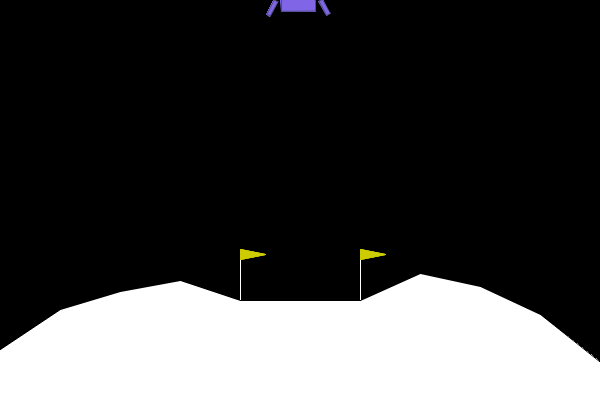

In [51]:
env = gym.make('LunarLander-v2')
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [52]:
MEMORY_SIZE = 100_000     # size of memory buffer
FACTOR = 0.995            # discount factor
LEARNING_RATE = 1e-3      # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MINIBATCH_SIZE = 64       # Mini-batch size
E_DECAY = 0.995           # ε-decay rate for the ε-greedy policy
E_MIN = 0.01              # Minimum ε value for the ε-greedy policy
TAU = 1e-3                # Soft update parameter

### Action Space

The agent has four discrete actions available:

* Do nothing = 0 <br>
* Fire right engine = 1 <br>
* Fire main engine = 2 <br>
* Fire left engine = 3 <br>

In [53]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [54]:
# Reset the environment and get the initial state.
initial_state = env.reset()

# Select an action
action = 0

# Run a single tim]e step of the environment's dynamics with the given action.
next_state, reward, done, _ = env.step(action)

# Display table with values. All values are displayed to 3 decimal places.
# utils.display_table(initial_state, action, next_state, reward, done)
print(f'Intitial State: {list(initial_state)}')
print(f'Action: {action}')
print(f'Next State: {list(next_state)}')
print(f'Reward: {reward}')
print(f'Espisode Terminated: {done}')

Intitial State: [-0.006838703, 1.4010947, -0.69269174, -0.43671146, 0.0079310285, 0.15690503, 0.0, 0.0]
Action: 0
Next State: [-0.013677788, 1.3906933, -0.6917559, -0.46234876, 0.015684186, 0.15507892, 0.0, 0.0]
Reward: -1.057924562890264
Espisode Terminated: False


To solve the Lunar Lander environment, we are going to employ a DQN with the following architecture:

* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.

Having a moving target all the time might cause oscillations and instability. We can design a different neural network just for resulting in the $y$ targets to prevent this. This different neural network will have the same architecture as the original **Q-Network** and will be referred to as the **target $\hat Q$-Network**.


In [55]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear')
])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),                       
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear')
])

optimizer = Adam(learning_rate=LEARNING_RATE) 

By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [56]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

Lastly, compute the loss by calculating the Mean-Squared Error (`MSE`) between the `y_targets` and the `q_values`. To calculate the mean-squared error you should use the already imported package MSE.

In [57]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    # Calculate the loss
    loss = MSE(y_targets, q_values)
    return loss

In [58]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

@tf.function
def agent_learn(experiences, discount_factor):
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, discount_factor, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

# Training model for Agent

In [59]:
import random

def get_action(q_values, epsilon=0.0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))

def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), 
        dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), 
        dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), 
        dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), 
        dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY * epsilon)

In [ ]:
def Train_Model():
  start = time.time()
  num_episodes = 1000
  max_num_timesteps = 1000

  total_point_history = []

  num_p_av = 100    # number of total points to use for averaging
  epsilon = 1.0     # initial ε value for ε-greedy policy

  # Create a memory buffer D with capacity N
  memory_buffer = deque(maxlen=MEMORY_SIZE)

  # Set the target network weights equal to the Q-Network weights
  target_q_network.set_weights(q_network.get_weights())

  for i in range(num_episodes):
      # Reset the environment to the initial state and get the initial state
      state = env.reset()
      total_points = 0
      for t in range(max_num_timesteps):
          # From the current state S choose an action A using an ε-greedy policy
          state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
          q_values = q_network(state_qn)
          action = get_action(q_values, epsilon)
          # Take action A and receive reward R and the next state S'
          next_state, reward, done, _ = env.step(action)
          # Store experience tuple (S,A,R,S') in the memory buffer.
          # We store the done variable as well for convenience.
          memory_buffer.append(experience(state, action, reward, next_state, done))
          # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
          update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
          if update:
              # Sample random mini-batch of experience tuples (S,A,R,S') from D
              experiences = get_experiences(memory_buffer)
              # Set the y targets, perform a gradient descent step,
              # and update the network weights.
              agent_learn(experiences, FACTOR)
          state = next_state.copy()
          total_points += reward
          if done: break
      total_point_history.append(total_points)
      av_latest_points = np.mean(total_point_history[-num_p_av:])
      
      # Update the ε value
      epsilon = get_new_eps(epsilon)
      print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
      if (i+1) % num_p_av == 0:
           print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
      # We will consider that the environment is solved if we get an
      # average of 200 points in the last 100 episodes.
      if av_latest_points >= 200.0:
          print(f"\n\nEnvironment solved in {i+1} episodes!")
          q_network.save('lunar_lander_model.h5')
          break
  print(f"\nTotal Runtime: {time.time() - start} s ({(time.time() - start)/60} min)")
  return q_network, total_point_history

Now we try to train the model, in case the model already deployed, we just load it to save time for next time of train.

In [63]:
try: 
  q_network = tf.keras.models.load_model('lunar_lander')
  total_point_history = [float(line.rstrip()) for line in open('HistoryPoint.txt')]
except:
  q_network, total_point_history = Train_Model()
  # write result to store history points
  with open('HistoryPoint.txt', 'w') as fs:
    fs.write('\n'.join([str(i) for i in total_point_history]))

Episode 100 | Total point average of the last 100 episodes: -98.57
Episode 200 | Total point average of the last 100 episodes: -39.98
Episode 300 | Total point average of the last 100 episodes: 9.79
Episode 400 | Total point average of the last 100 episodes: 170.44
Episode 471 | Total point average of the last 100 episodes: 199.95

Episode 472 | Total point average of the last 100 episodes: 200.54

Environment solved in 472 episodes!

Total Runtime: 856.8848040103912 s (14.28141352335612 min)


In [68]:
from PlotingHistory import *

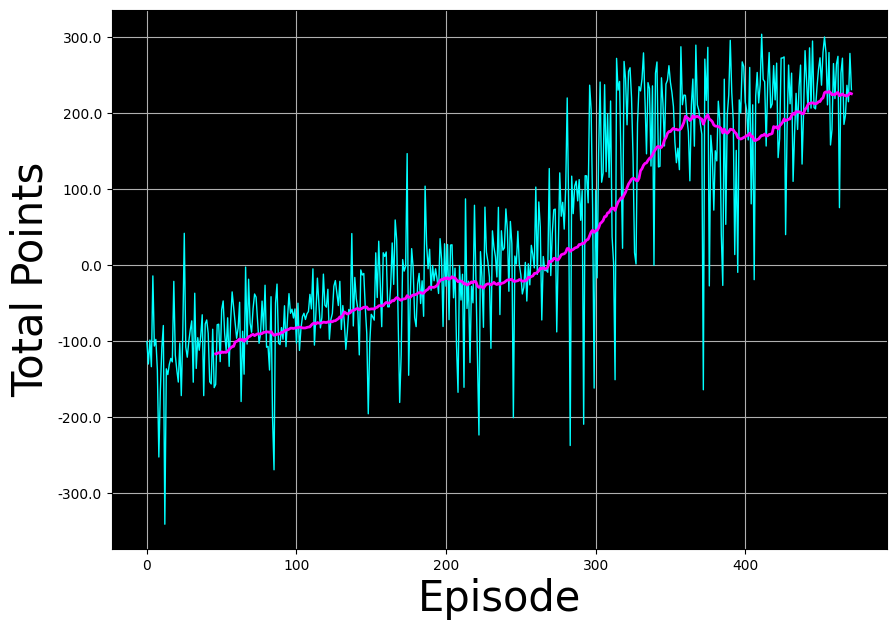

In [69]:
plot_history(total_point_history)